In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

%matplotlib inline

Количество столбцов равно 15

Проверим это и удалим строки, где количество столбцов меньше

In [2]:
sum = 0
with open('test_task_ml/data.txt', 'r') as outfile, open('new_data.txt', 'w') as infile:
    for line in outfile:
        line_length = len(line.split(','))
        if  line_length < 15: 
            sum += 1
            continue
        elif line_length == 15:
            infile.write(line)
print('Удалено строк: ', sum)

Удалено строк:  3


Загрузим данные

In [3]:
column_names = [
    'age',
    'workclass',
    'final_weight',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'cap-gain',
    'cap-loss',
    'hours-per-week',
    'native-country',
    'comparison' # условие того, получает ли человек больше или меньше указанной суммы  
    
]

In [4]:
dtypes = {
    'age': 'int32',
    'workclass': 'category',
    'final_weight': 'float64',
    'education': 'category',
    'education-num': 'int32',
    'marital-status': 'category',
    'occupation': 'category',
    'relationship': 'category',
    'race': 'category',
    'sex': 'category',
    'cap-gain': 'float64',
    'cap-loss': 'float64',
    'hours-per-week': 'int32',
    'native-country': 'category',
    'comparison': 'category'
}

In [5]:
train_data = pd.read_csv('new_data.txt', names=column_names, dtype=dtypes)

In [6]:
train_data.head()

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,comparison
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40,United-States,<=N
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13,United-States,<=N
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40,United-States,<=N
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40,United-States,<=N
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40,Cuba,<=N


In [7]:
train_data.dtypes

age                  int32
workclass         category
final_weight       float64
education         category
education-num        int32
marital-status    category
occupation        category
relationship      category
race              category
sex               category
cap-gain           float64
cap-loss           float64
hours-per-week       int32
native-country    category
comparison        category
dtype: object

In [8]:
def category_to_lower_case(df):
    for col in df.columns:
        if col not in df._get_numeric_data().columns:
            df[col] = df[col].apply(lambda x: x.lower())

In [9]:
category_to_lower_case(train_data)

In [10]:
for col in train_data.columns:
    print('Column name: ', col)
    print(train_data[col].unique())

Column name:  age
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
  1 87]
Column name:  workclass
[' state-gov', ' self-emp-not-inc', ' private', ' federal-gov', ' local-gov', ' ?', ' self-emp-inc', ' without-pay', ' never-worked']
Categories (9, object): [' state-gov', ' self-emp-not-inc', ' private', ' federal-gov', ..., ' ?', ' self-emp-inc', ' without-pay', ' never-worked']
Column name:  final_weight
[ 77516.  83311. 215646. ...  34066.  84661. 257302.]
Column name:  education
[' bachelors', ' hs-grad', ' 11th', ' masters', ' 9th', ..., ' 5th-6th', ' 10th', ' 1st-4th', ' preschool', ' 12th']
Length: 16
Categories (16, object): [' bachelors', ' hs-grad', ' 11th', ' masters', ..., ' 10th', ' 1st-4th', ' preschool', ' 12th']
Column name:  education-num
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Column name:  m

In [11]:
train_data.shape

(32571, 15)

Так как данная задача сводится к бинарной классификации, то заменим в исходе категориальные признаки следующим образом:

меньше N -> 0

больше N -> 1

In [12]:
new_train_data = train_data.copy()
le = LabelEncoder()
new_train_data['comparison'] = le.fit_transform(new_train_data['comparison'])

In [13]:
new_train_data.head()

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,comparison
0,39,state-gov,77516.0,bachelors,13,never-married,adm-clerical,not-in-family,white,male,2174.0,0.0,40,united-states,0
1,50,self-emp-not-inc,83311.0,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,0.0,0.0,13,united-states,0
2,38,private,215646.0,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,0.0,0.0,40,united-states,0
3,53,private,234721.0,11th,7,married-civ-spouse,handlers-cleaners,husband,black,male,0.0,0.0,40,united-states,0
4,28,private,338409.0,bachelors,13,married-civ-spouse,prof-specialty,wife,black,female,0.0,0.0,40,cuba,0


In [14]:
train_data.isnull().sum()

age               0
workclass         0
final_weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
cap-gain          0
cap-loss          0
hours-per-week    0
native-country    0
comparison        0
dtype: int64

In [15]:
train_data.nunique()

age                  74
workclass             9
final_weight      21649
education            16
education-num        16
marital-status        7
occupation           15
relationship          7
race                  5
sex                   3
cap-gain            120
cap-loss             93
hours-per-week       95
native-country       42
comparison            2
dtype: int64

Как можно видеть в данном тренировочном наборе отсутствуют строки, где какой-либо признак имел значение NaN

Рассмотрим, как распределились записи в зависимости от класса >N или <=N

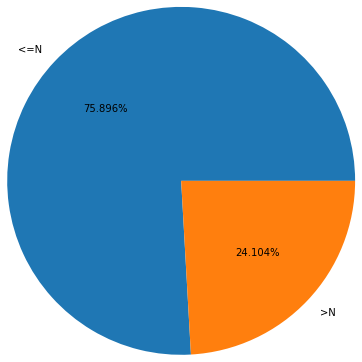

In [16]:
smaller, bigger = new_train_data['comparison'].value_counts()

plt.pie(x=[smaller, bigger], labels=['<=N', '>N'], autopct='%1.3f%%', radius=2)
plt.show()

Как можно видеть на круговой диаграмме тренировочный набор данных имеет сильное смещение в пользу класса <=N

Рассмотрим распределение значений в некоторых столбцах

In [17]:
from matplotlib.pyplot import figure

sns.set(rc={'figure.figsize':(20,15)})

<AxesSubplot:xlabel='age', ylabel='Count'>

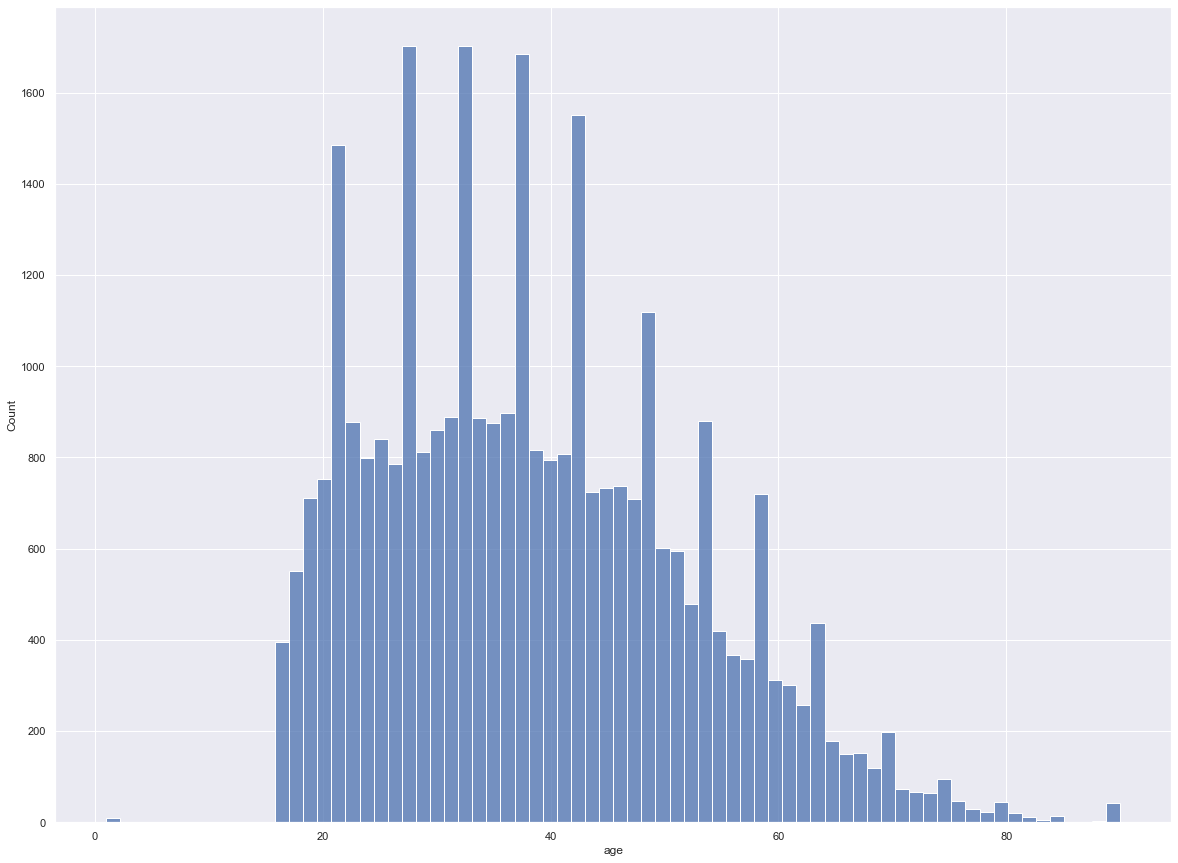

In [18]:
sns.histplot(data=new_train_data, x="age")

Можно видеть, что возраст некоторых опрошенных близко к 0.

Рассмотрим эти записи

In [19]:
new_train_data[new_train_data.age < 17]

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,comparison
26555,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1
26556,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1
26557,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1
26558,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1
26559,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1
26560,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1
26561,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1
26562,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1
26563,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1
26564,1,state-gov,-42141.0,some-college,10,never-married,machine-op-inspct,sales,black,other,100.0,-110.0,-1911779654,united-states,1


Данные имеют некоторые аномалии, например возраст равен 1 и количество часов работы в неделю меньше 0.

Такие данные очень странные и их можно удалить из набора

In [20]:
new_train_data = new_train_data.loc[new_train_data['age'] >= 17]

In [21]:
new_train_data.age.unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47,
       46, 36, 79, 27, 67, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58,
       26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82,
       83, 84, 85, 86, 87])

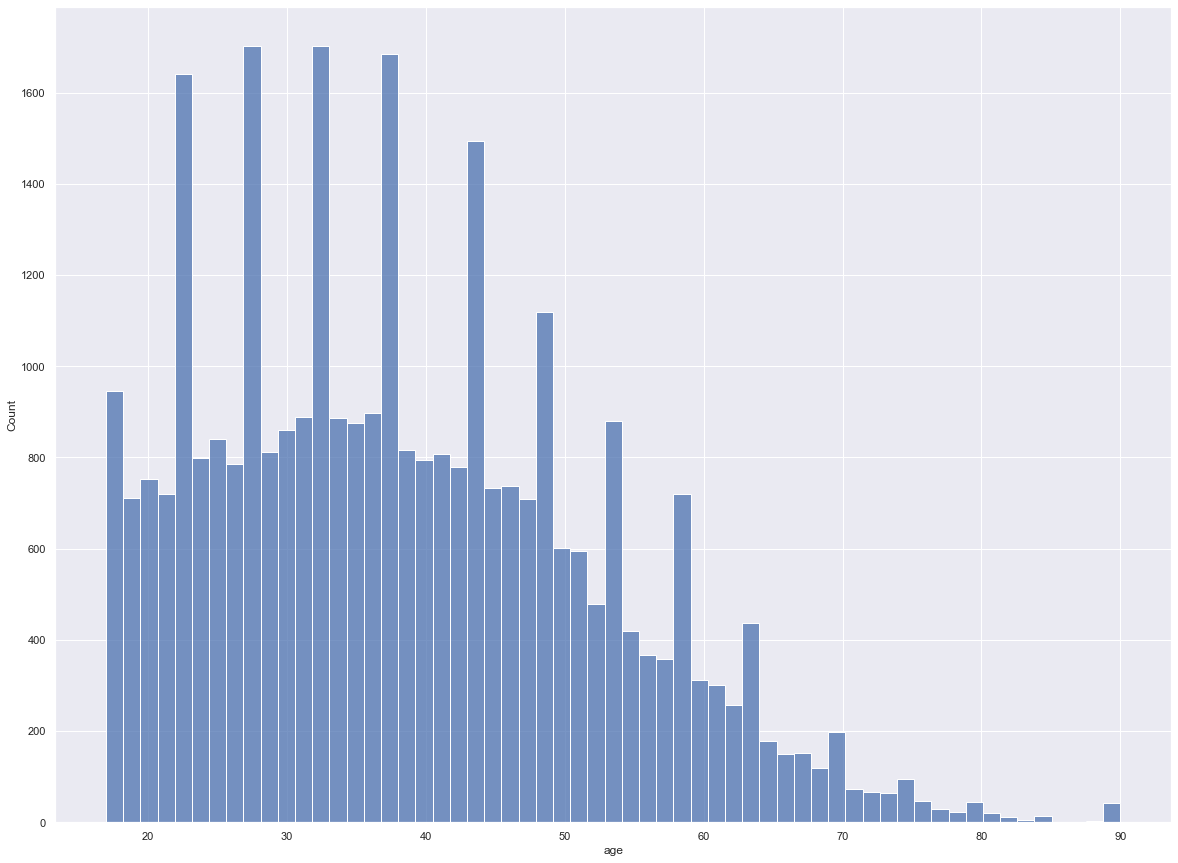

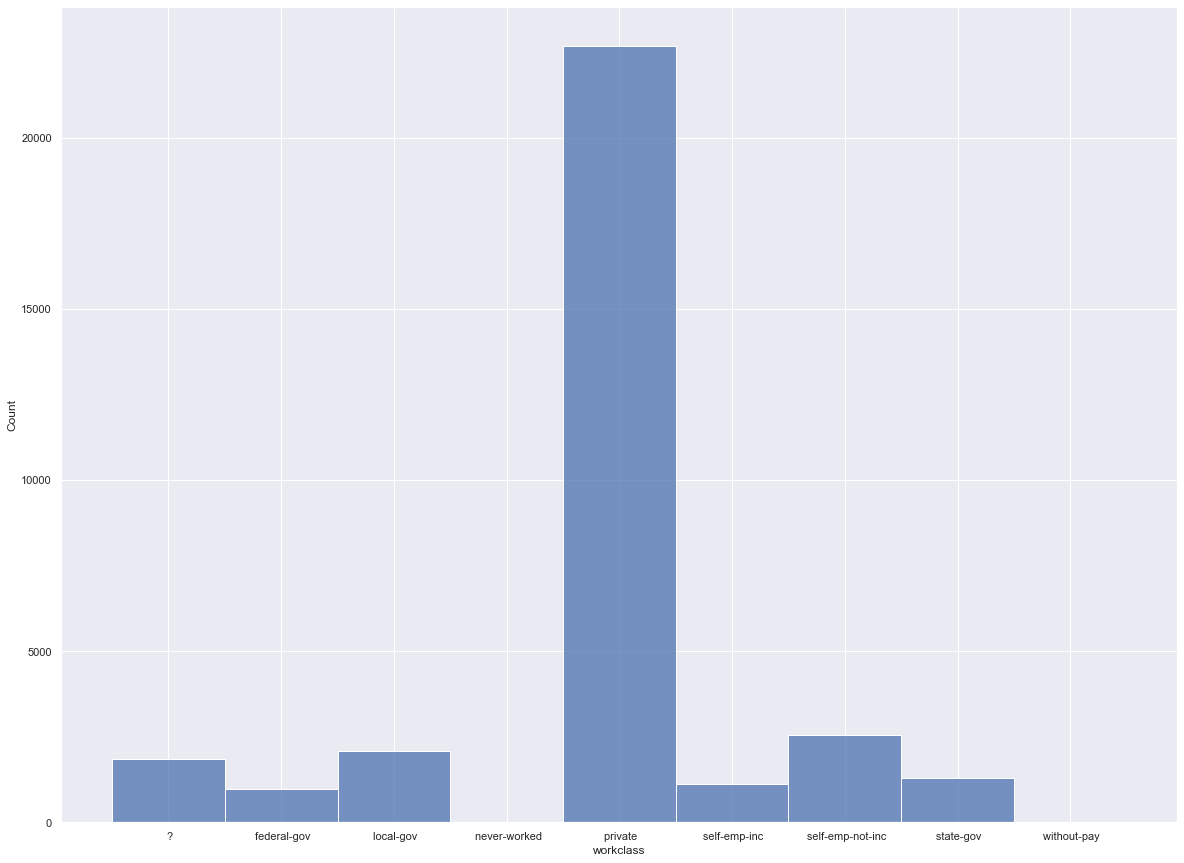

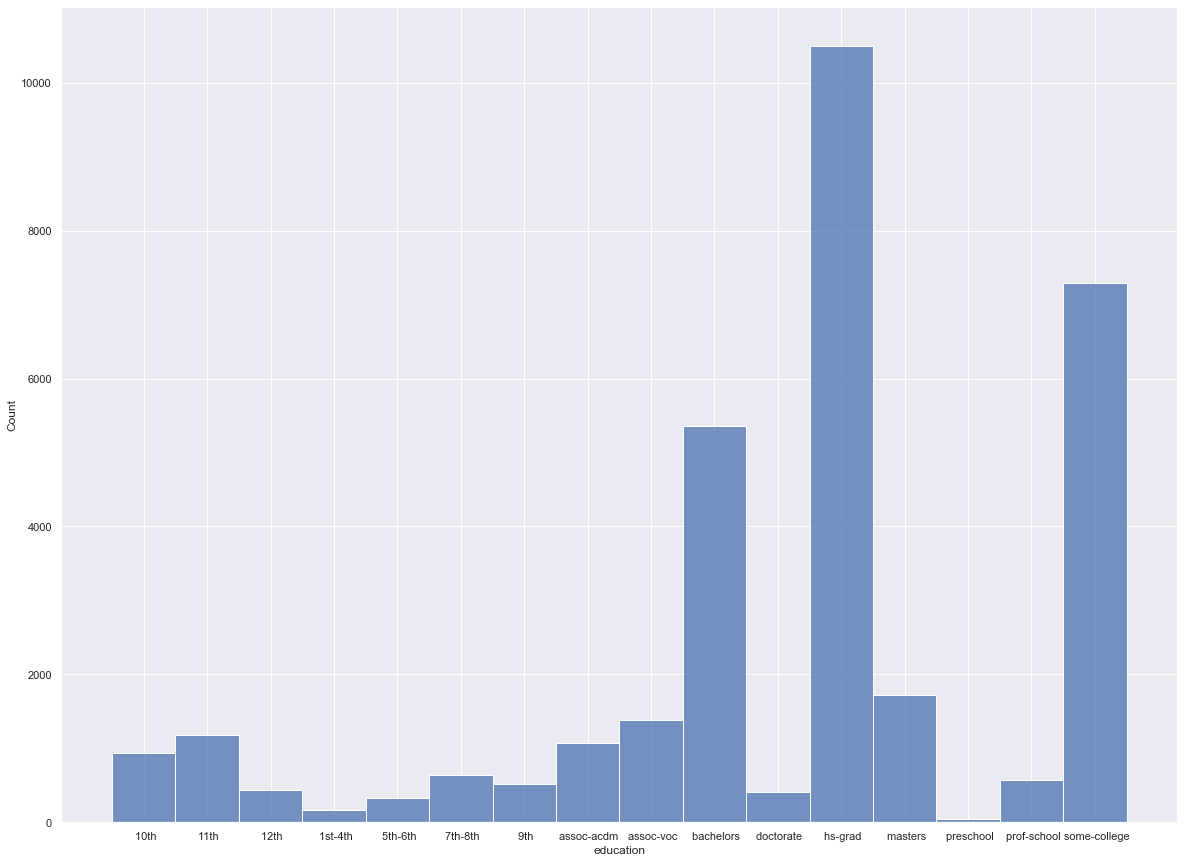

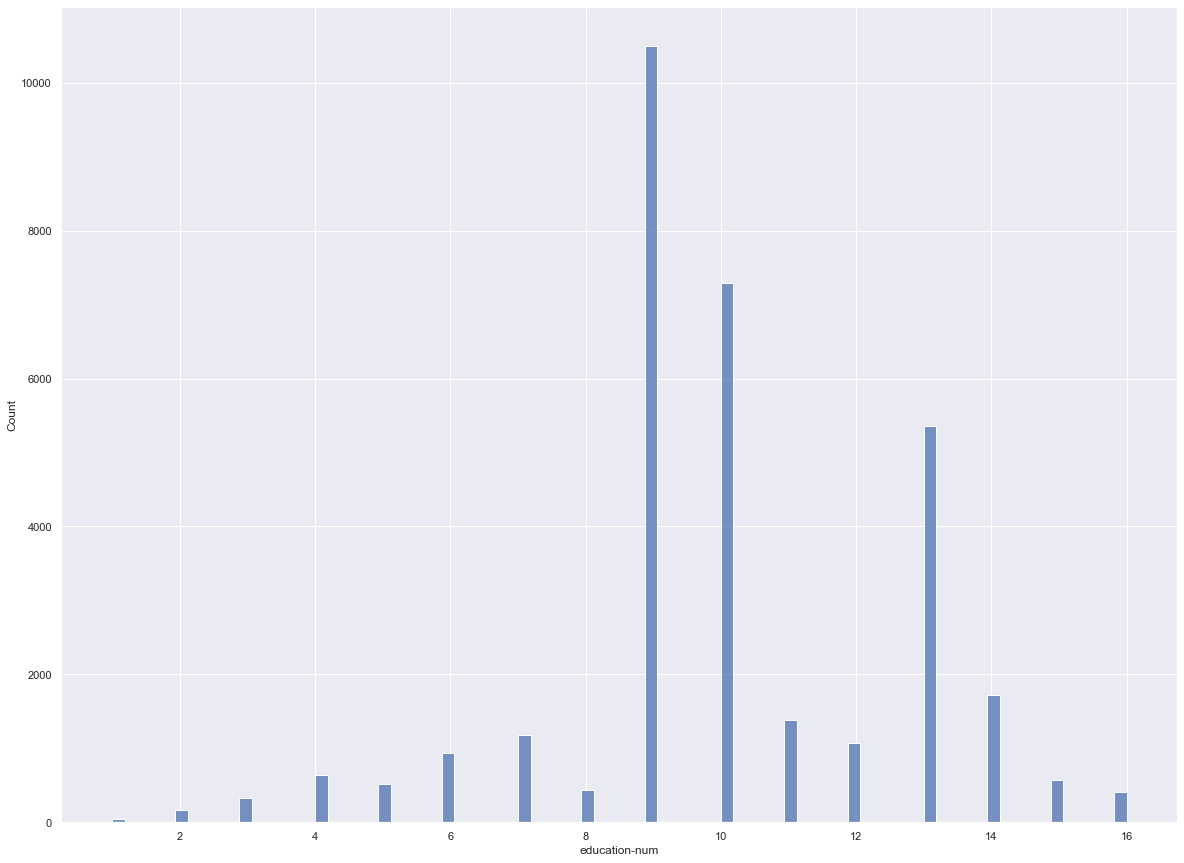

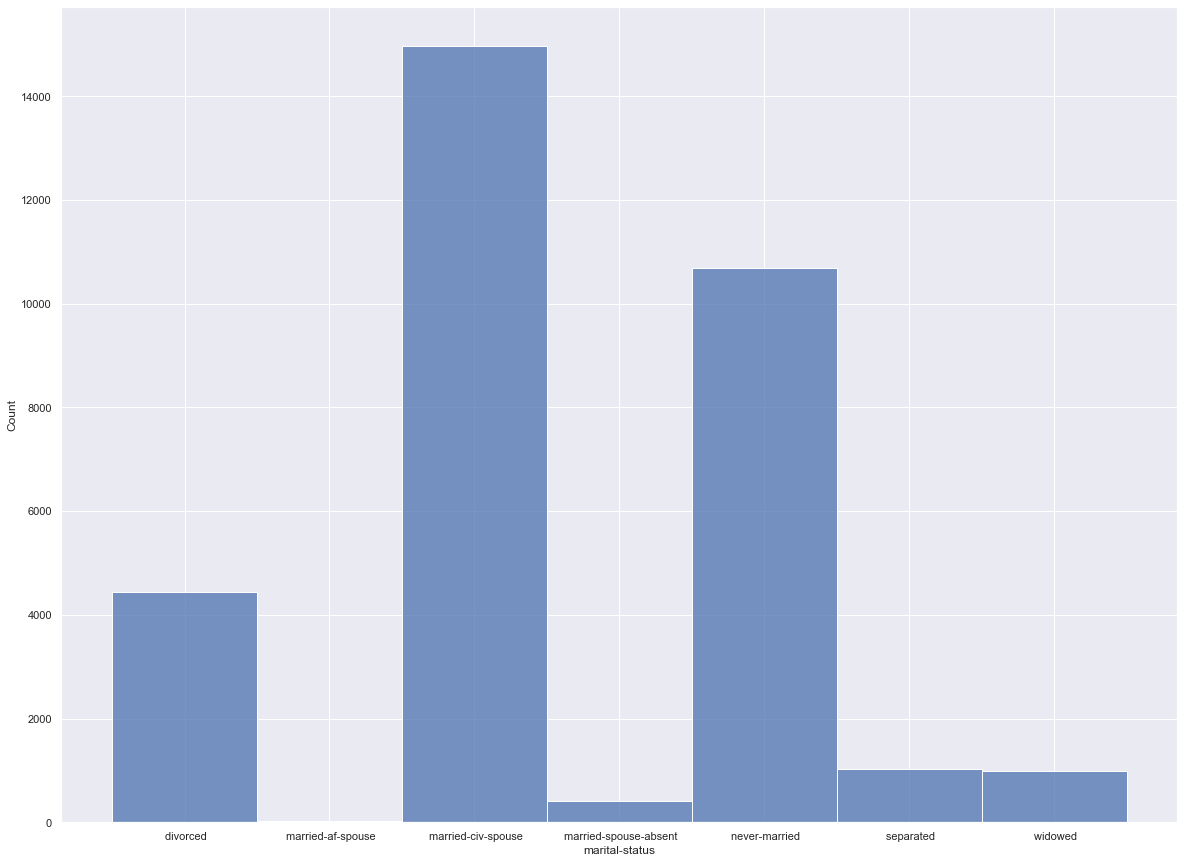

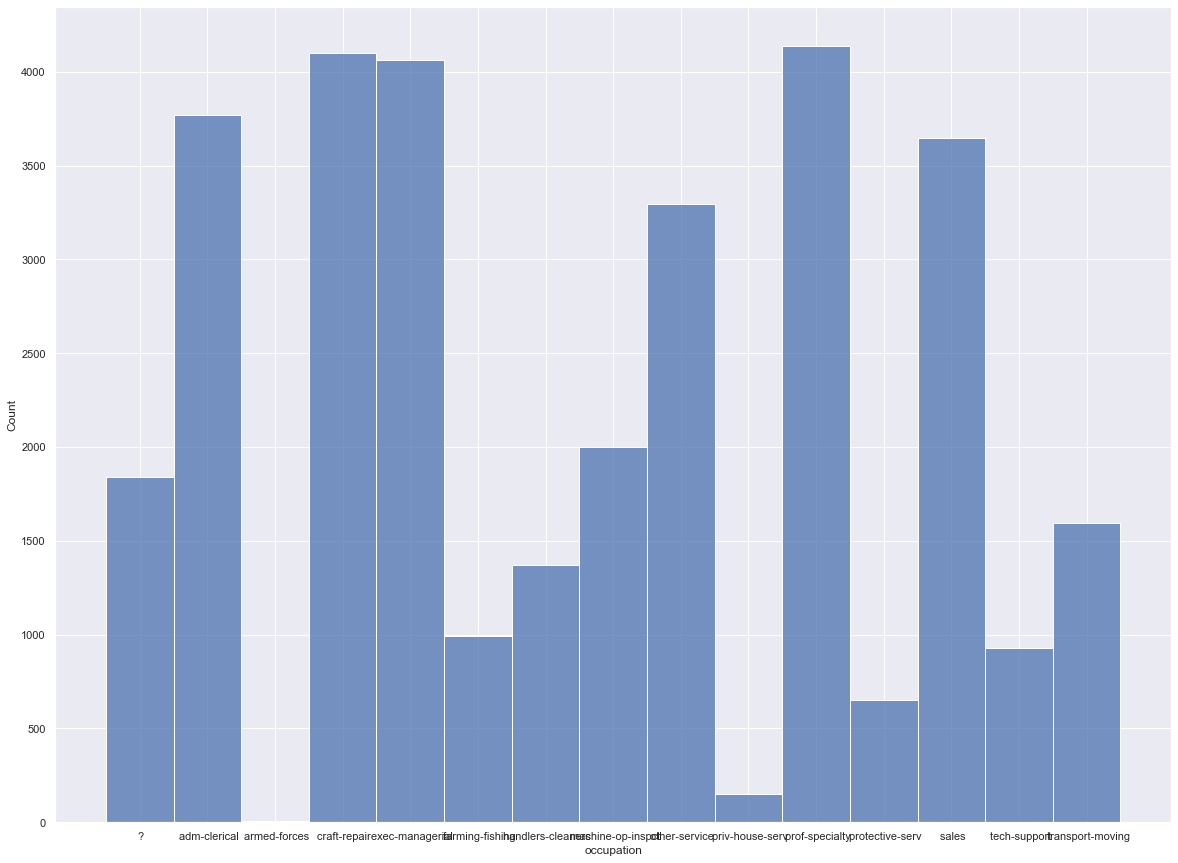

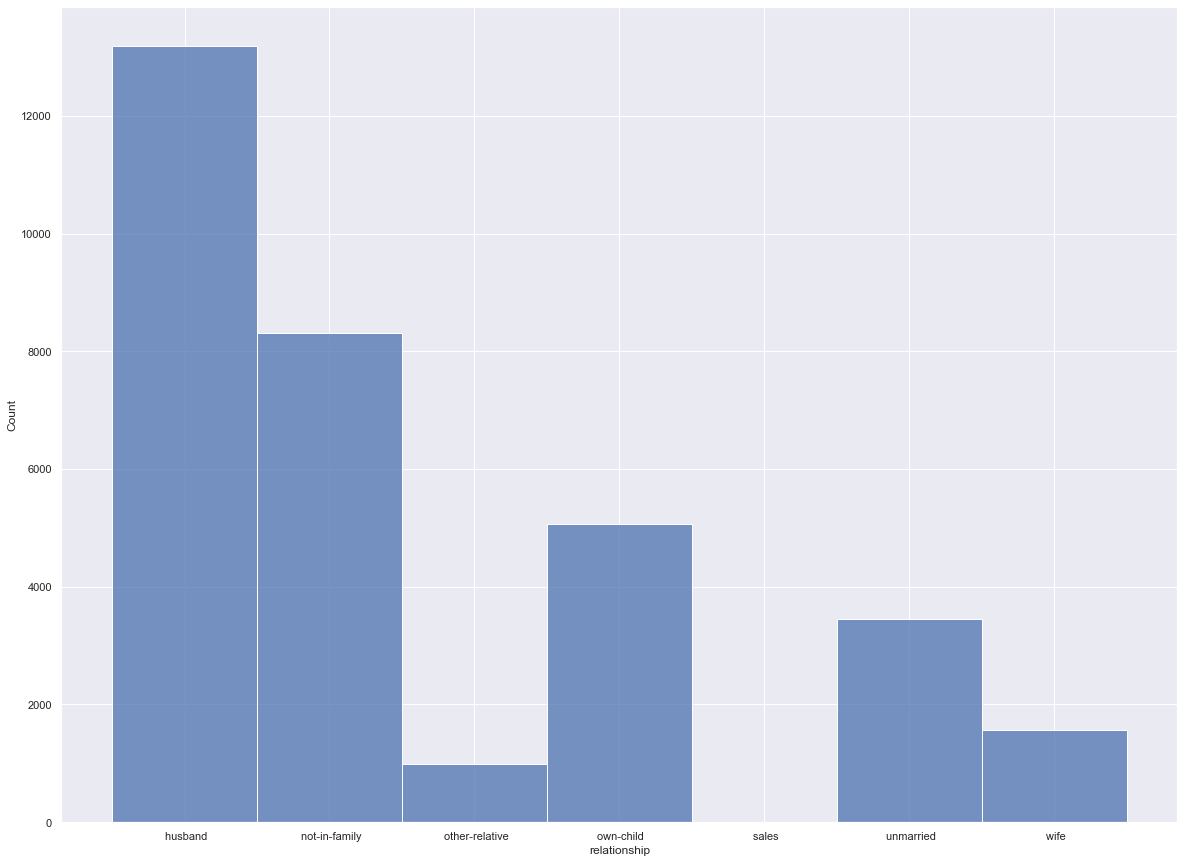

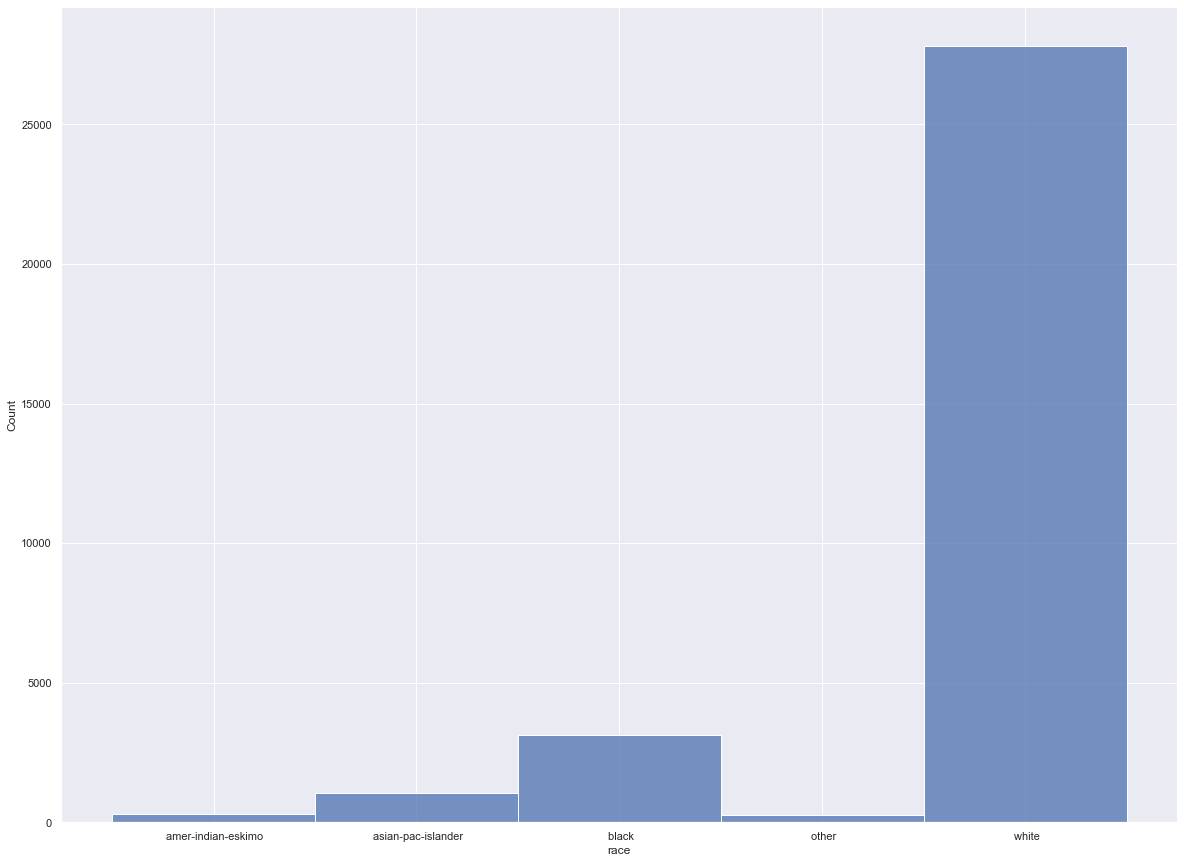

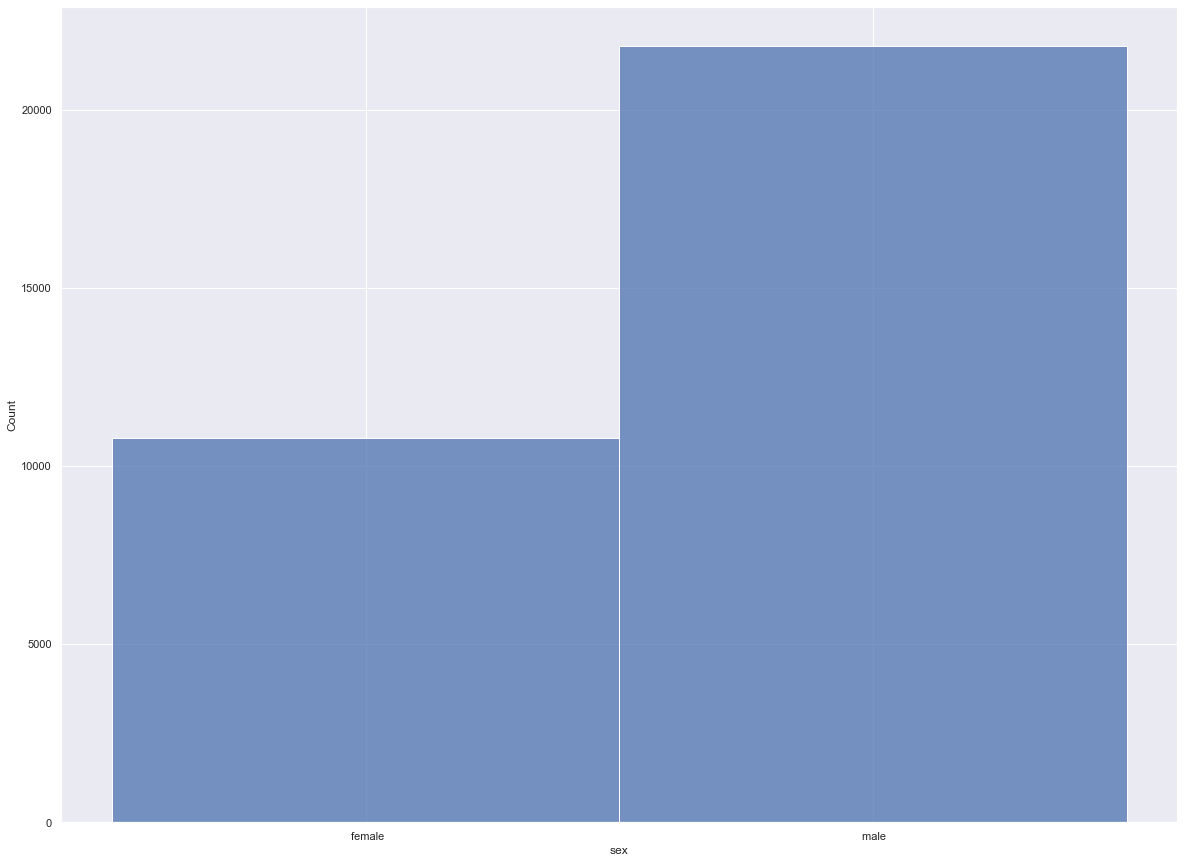

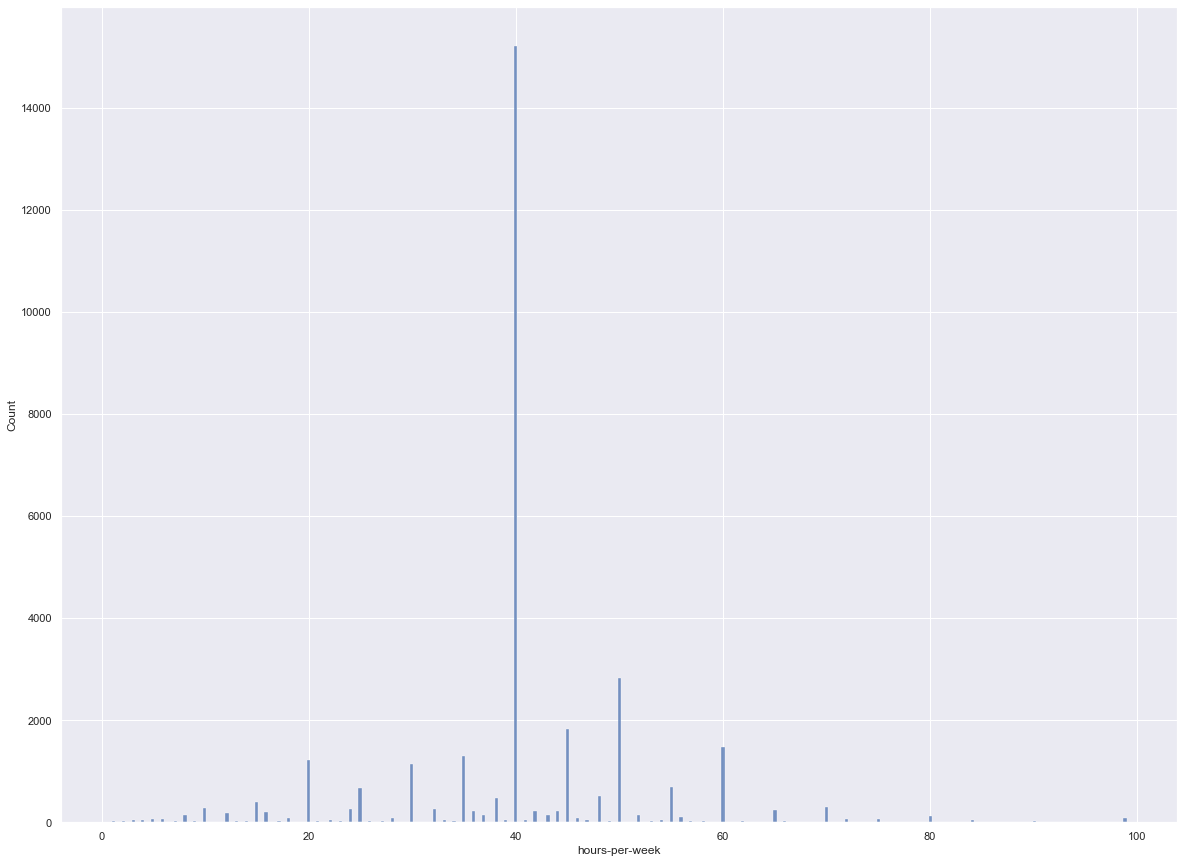

In [22]:
for i, col in enumerate(new_train_data.columns):
    if col not in ['final_weight', 'cap-gain', 'cap-loss', 'comparison', 'native-country']:
        plt.figure(i)
        sns.histplot(data=new_train_data, x=col)

In [23]:
new_train_data['native-country'].unique()

[' united-states', ' cuba', ' jamaica', ' india', ' ?', ..., ' vietnam', ' hong', ' ireland', ' hungary', ' holand-netherlands']
Length: 42
Categories (42, object): [' united-states', ' cuba', ' jamaica', ' india', ..., ' hong', ' ireland', ' hungary', ' holand-netherlands']

Рассмотрим некоторые числовые признаки

In [24]:
new_train_data['cap-loss'].value_counts()

0.0       31042
1902.0      202
1977.0      168
1887.0      159
1485.0       51
          ...  
1539.0        1
155.0         1
2282.0        1
2472.0        1
2201.0        1
Name: cap-loss, Length: 92, dtype: int64

In [25]:
new_train_data['cap-gain'].value_counts()

0.0        29849
15024.0      347
7688.0       284
7298.0       246
99999.0      159
           ...  
7978.0         1
2538.0         1
1639.0         1
4931.0         1
1111.0         1
Name: cap-gain, Length: 119, dtype: int64

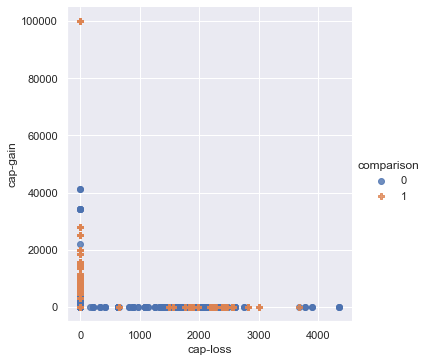

In [26]:
sns.lmplot(x='cap-loss', y='cap-gain', data=new_train_data, fit_reg=False, hue='comparison', markers=['o', 'P'])

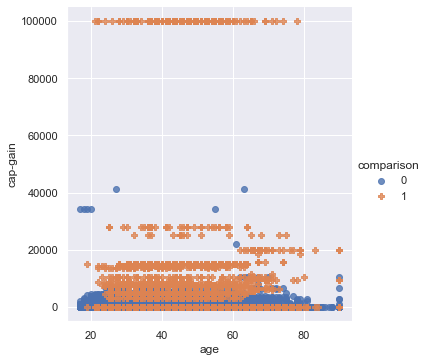

In [27]:
sns.lmplot(x='age', y='cap-gain', data=new_train_data, fit_reg=False, hue='comparison', markers=['o', 'P'])

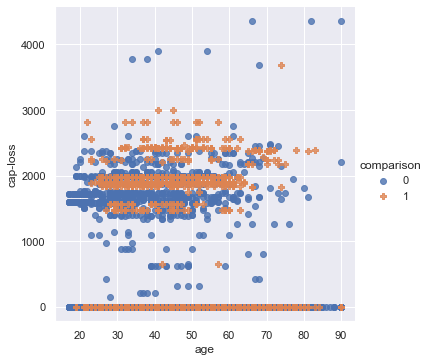

In [28]:
sns.lmplot(x='age', y='cap-loss', data=new_train_data, fit_reg=False, hue='comparison', markers=['o', 'P'])

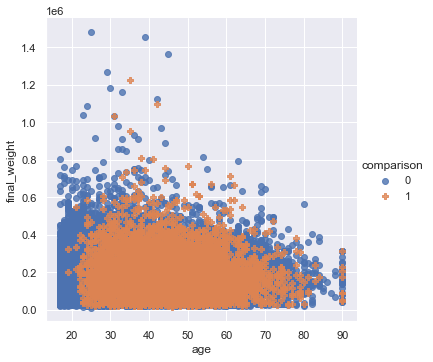

In [29]:
sns.lmplot(x='age', y='final_weight', data=new_train_data, fit_reg=False, hue='comparison', markers=['o', 'P'])

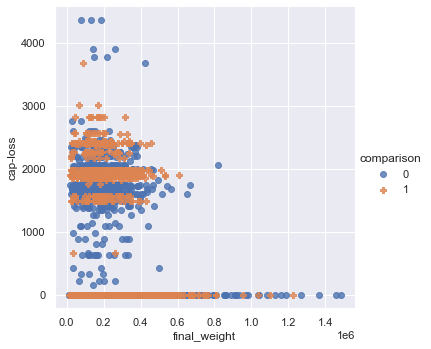

In [30]:
sns.lmplot(x='final_weight', y='cap-loss', data=new_train_data,
           fit_reg=False, hue='comparison', markers=['o', 'P'])

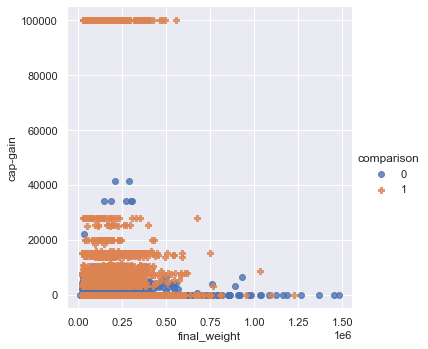

In [31]:
sns.lmplot(x='final_weight', y='cap-gain', data=new_train_data,
           fit_reg=False, hue='comparison', markers=['o', 'P'])

Рассмотрим выбросы в числовых данных

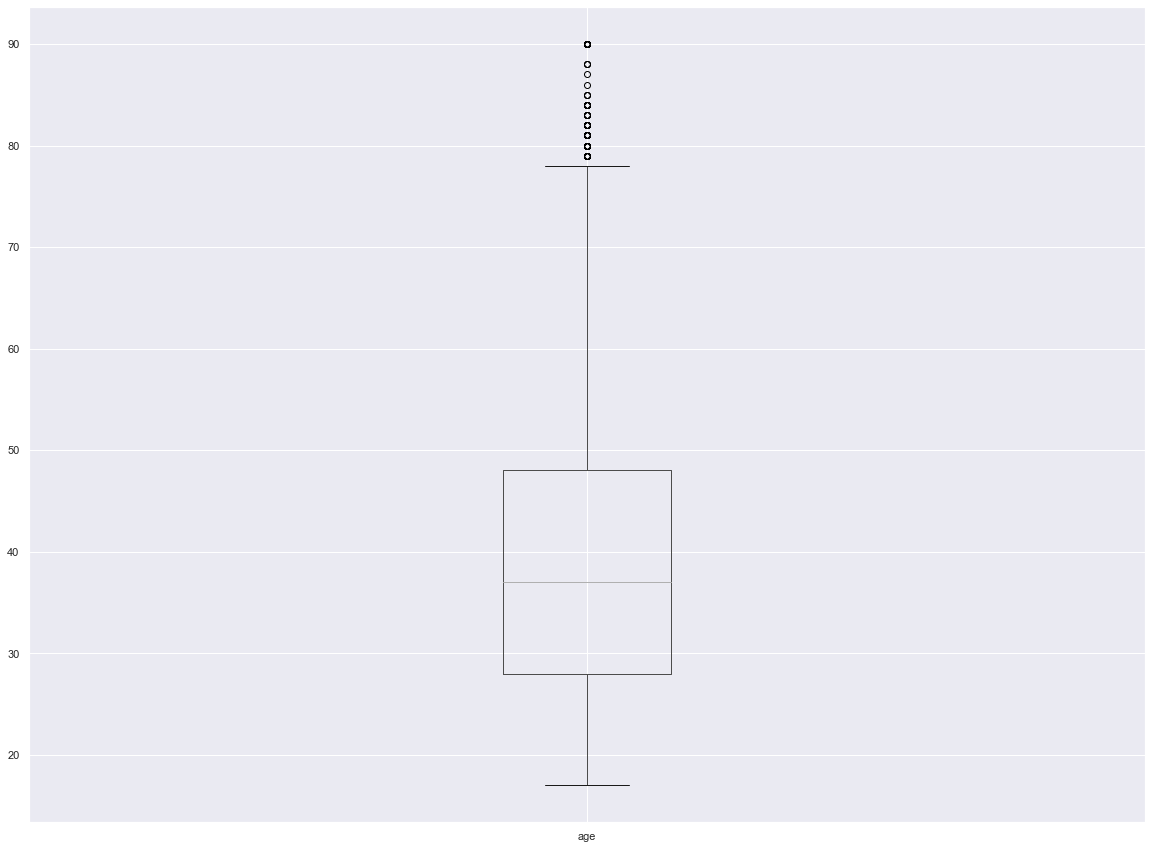

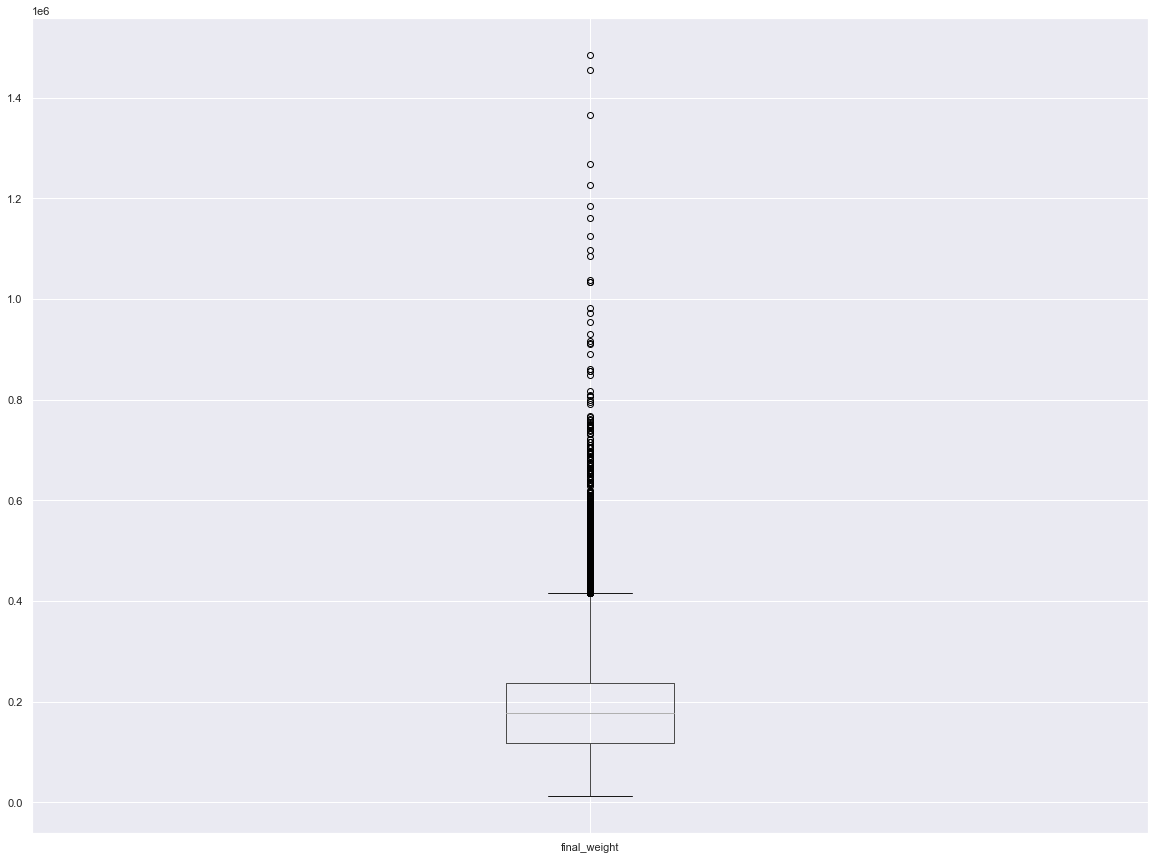

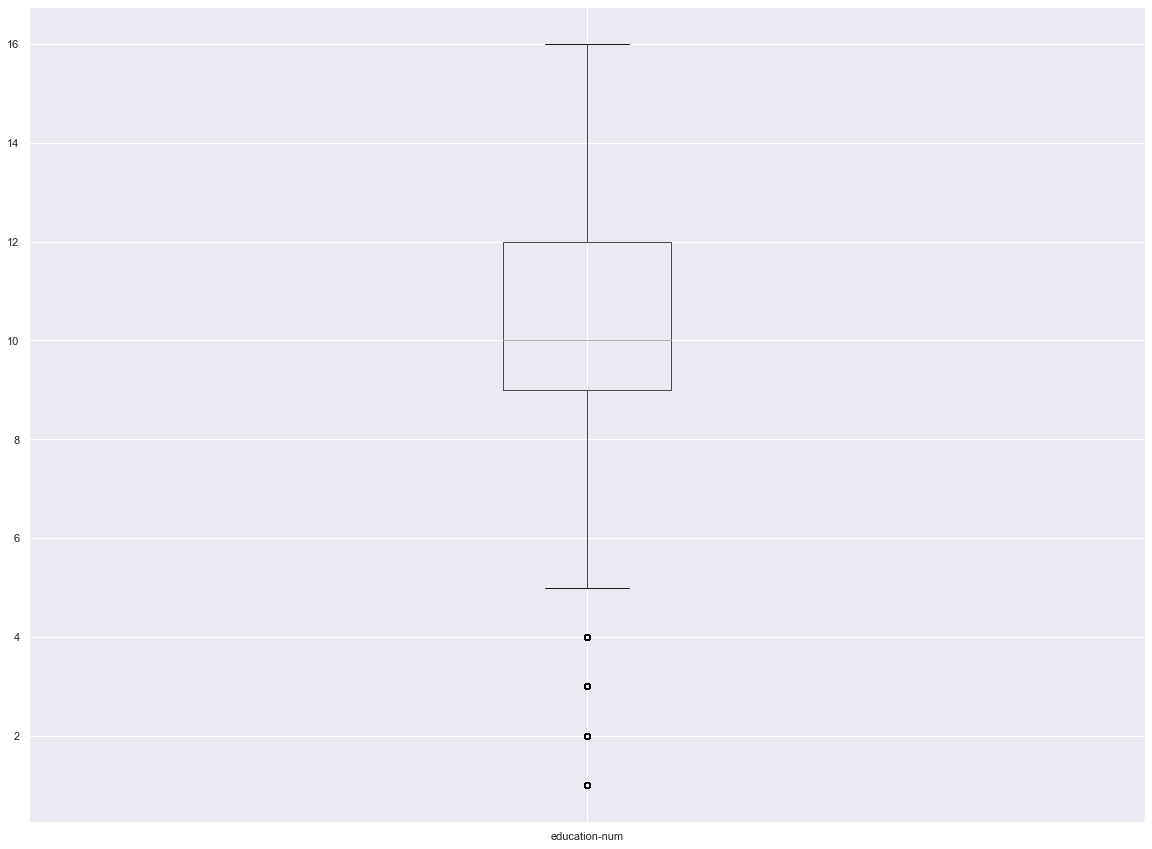

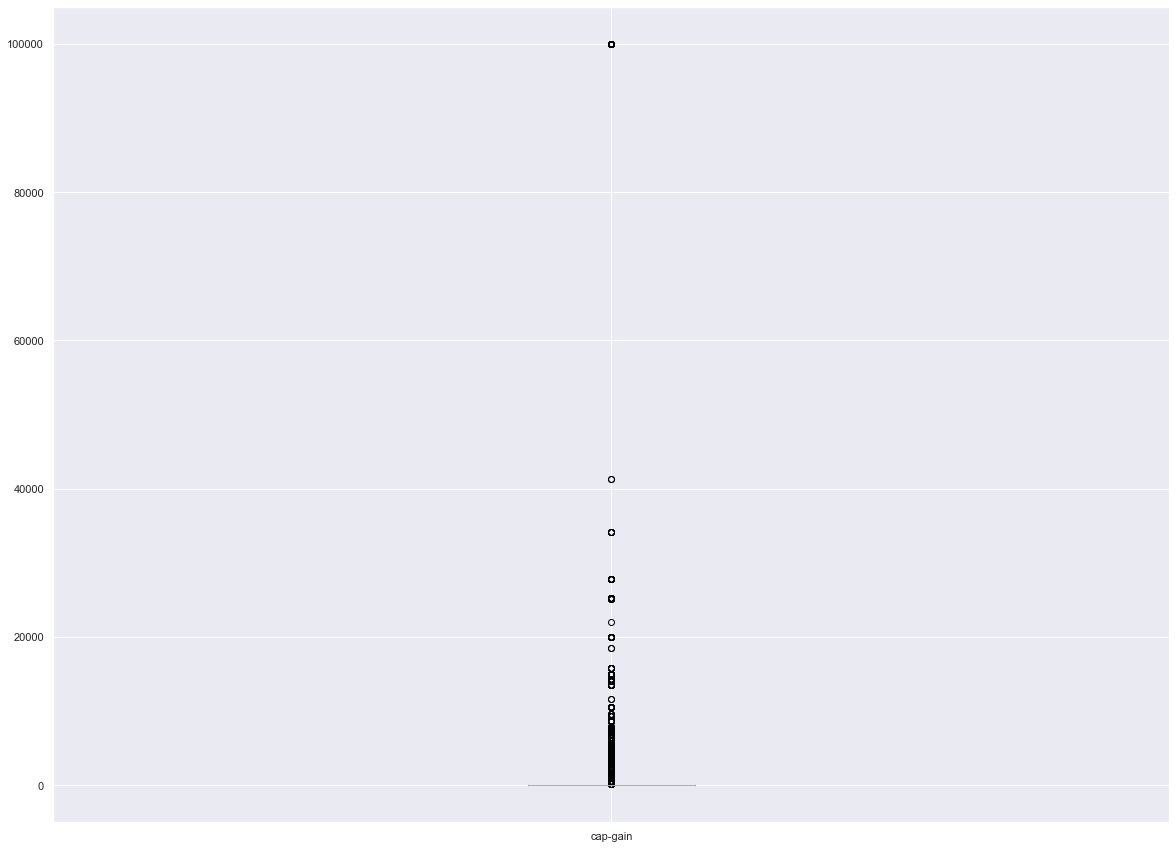

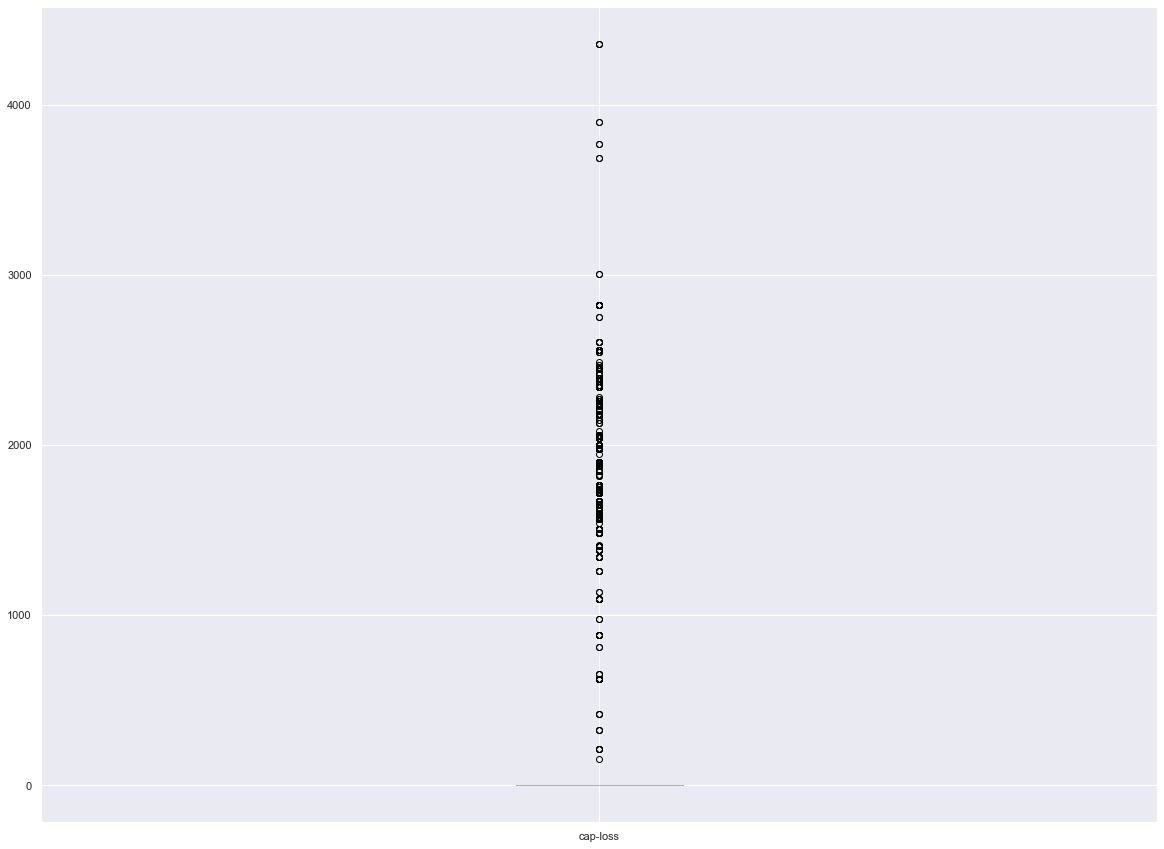

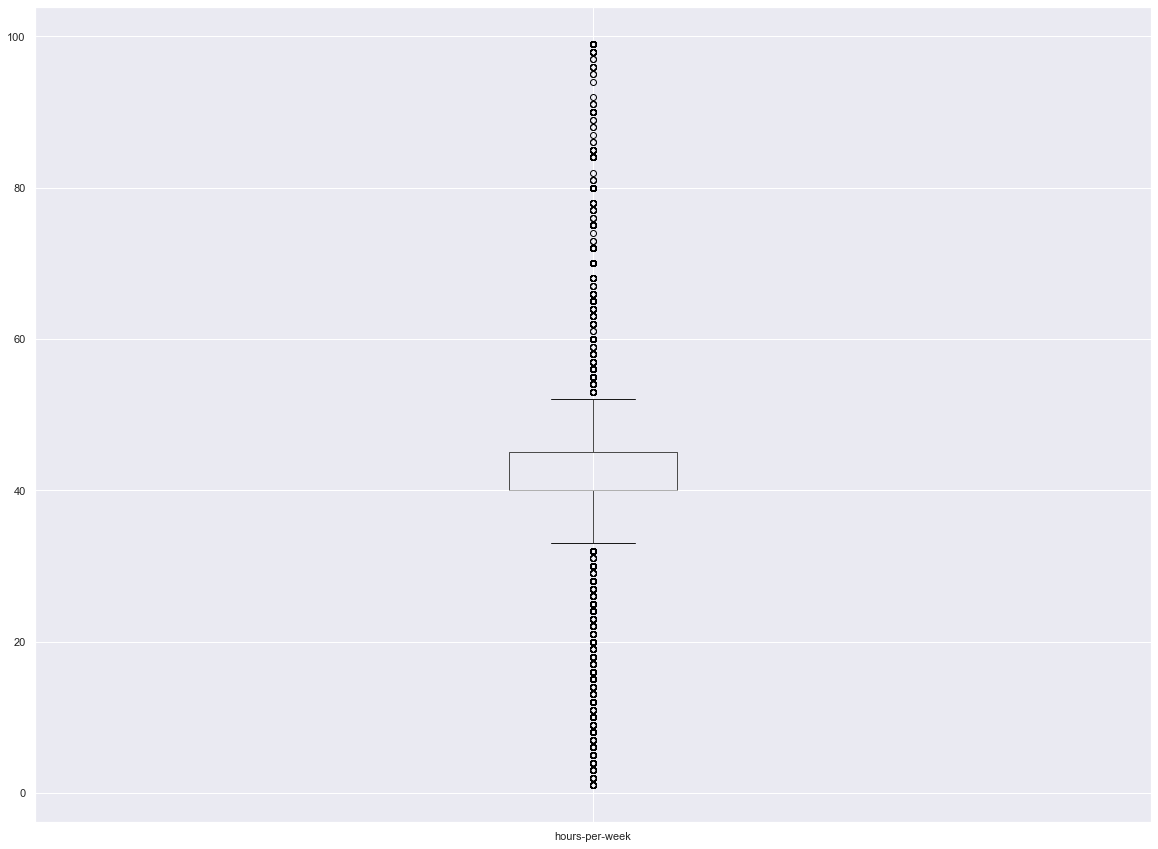

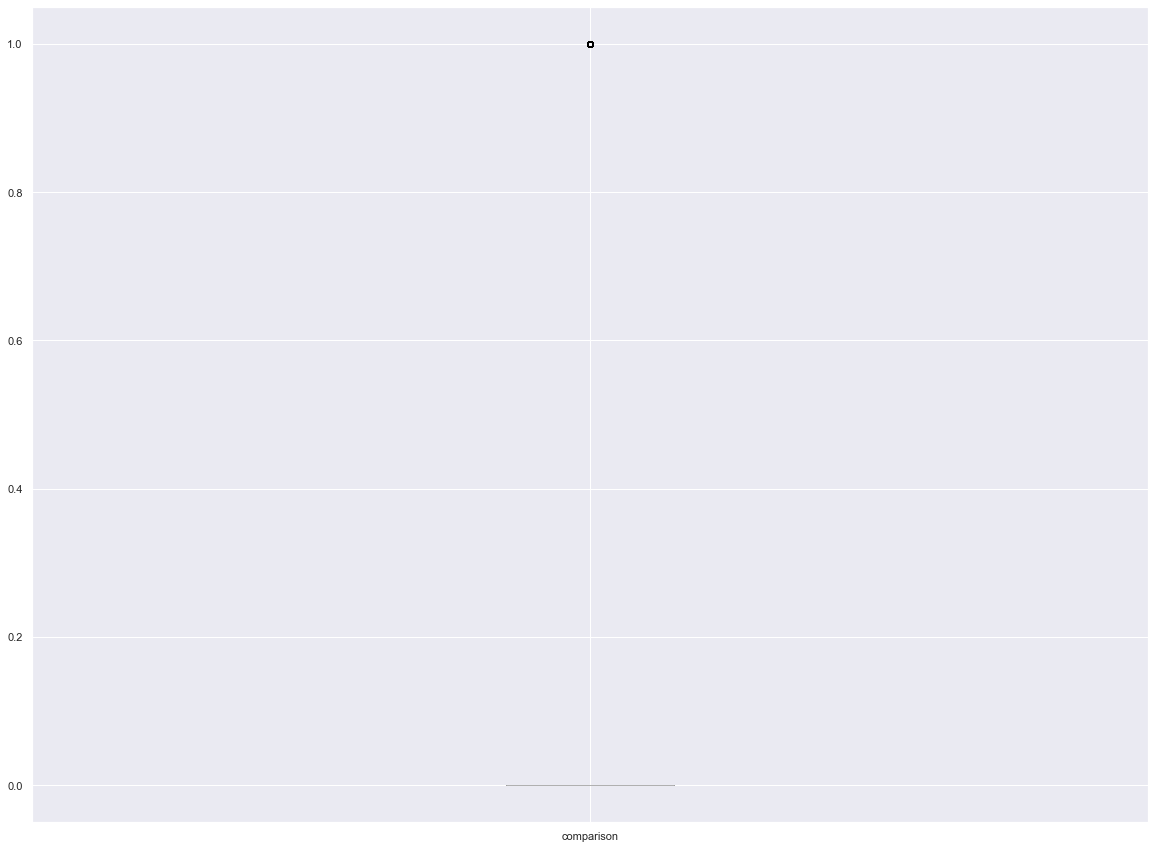

In [32]:
for i, col in enumerate(new_train_data._get_numeric_data().columns):
    plt.figure(i)
    new_train_data.boxplot(column=[col])

Рассмотрим распределение числовых данных

<Figure size 1440x1080 with 0 Axes>

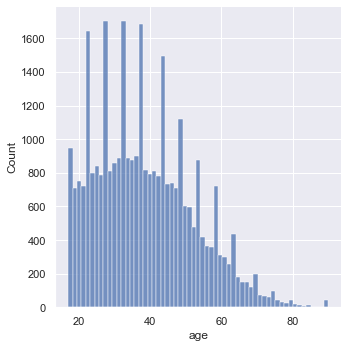

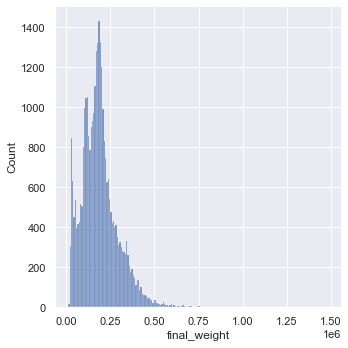

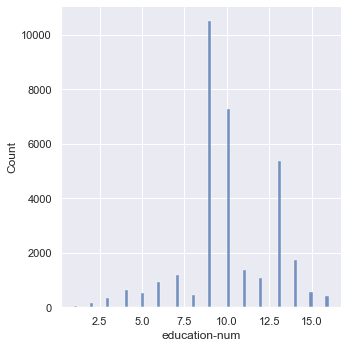

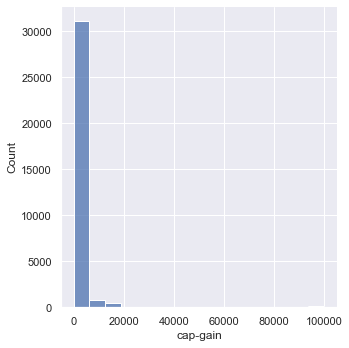

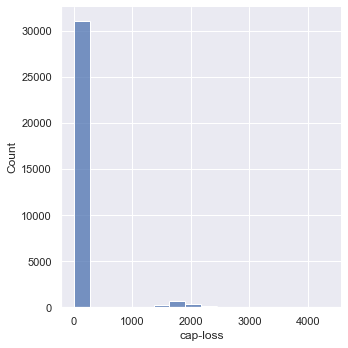

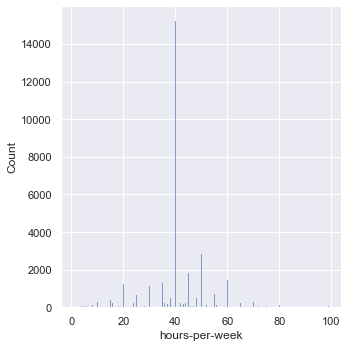

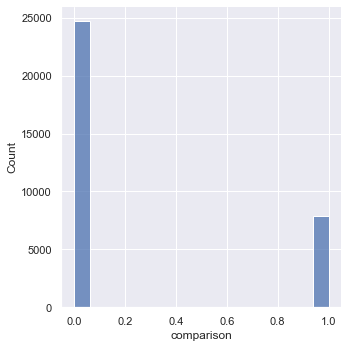

In [33]:
for index, col in enumerate(new_train_data._get_numeric_data().columns):
    plt.figure(index)
    sns.displot(new_train_data[col])

In [34]:
new_train_data.corr()

,age,final_weight,education-num,cap-gain,cap-loss,hours-per-week,comparison
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
final_weight,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
cap-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
cap-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
comparison,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


<AxesSubplot:>

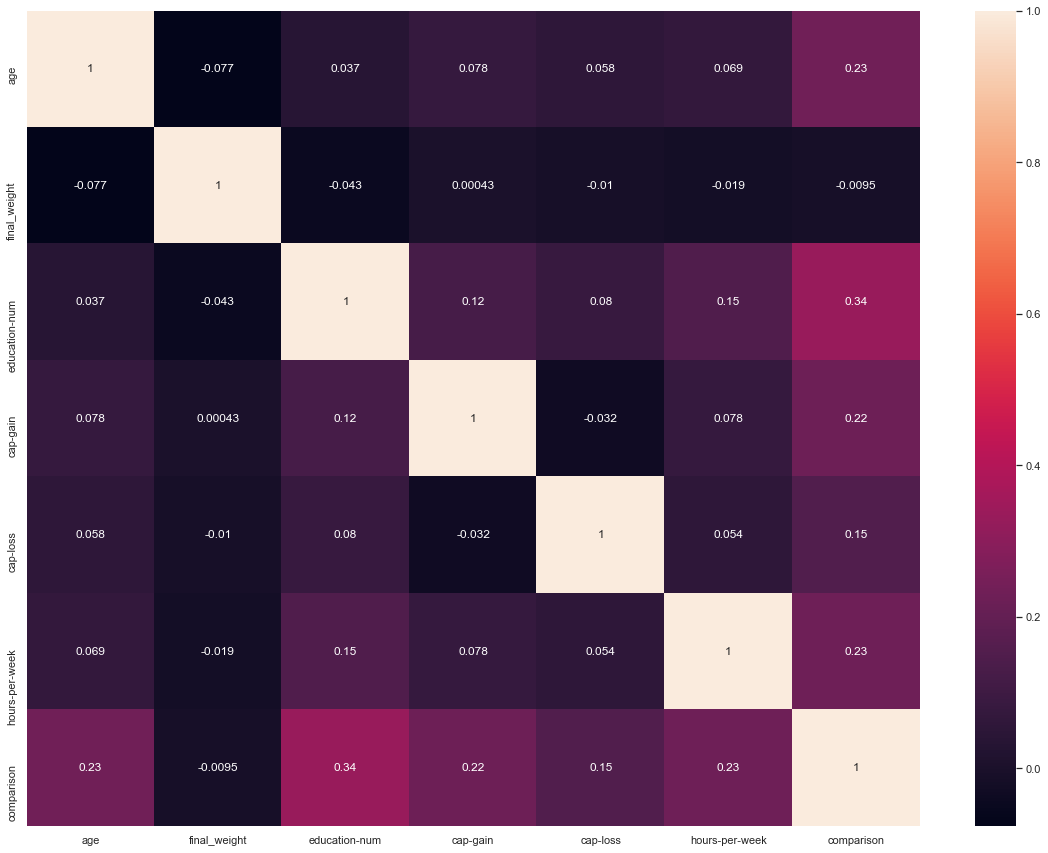

In [35]:
sns.heatmap(data=new_train_data.corr(), annot=True)

Можно было видеть из распределения cap-gain и cap-loss, что они не пересекаются практически

Поэтому введем признак cap-diff - прибыль, объединяющий эти два столбца

In [36]:
new_train_data['cap-diff'] = new_train_data['cap-gain'] - new_train_data['cap-loss']

In [37]:
new_train_data['cap-diff'].value_counts()

 0.0        28330
 15024.0      347
 7688.0       284
 7298.0       246
-1902.0       202
            ...  
-2467.0         1
-2201.0         1
-2080.0         1
 4931.0         1
-155.0          1
Name: cap-diff, Length: 210, dtype: int64

<AxesSubplot:>

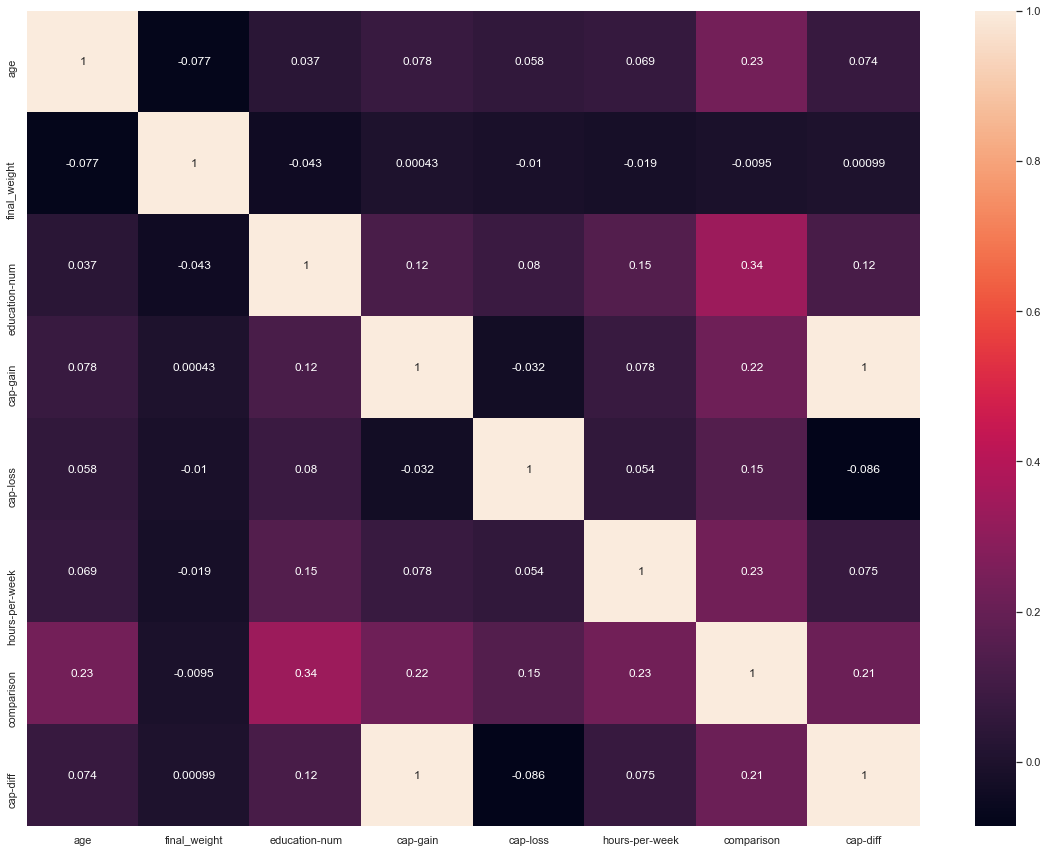

In [38]:
sns.heatmap(data=new_train_data.corr(), annot=True)

Введем еще один признка has_pos_cap, если у данной персоны имеется положительная прибыль

In [39]:
new_train_data['has_pos_cap'] = new_train_data['cap-diff'] >= 0
new_train_data['has_pos_cap'] = new_train_data['has_pos_cap'].apply(lambda x: int(x))

<AxesSubplot:>

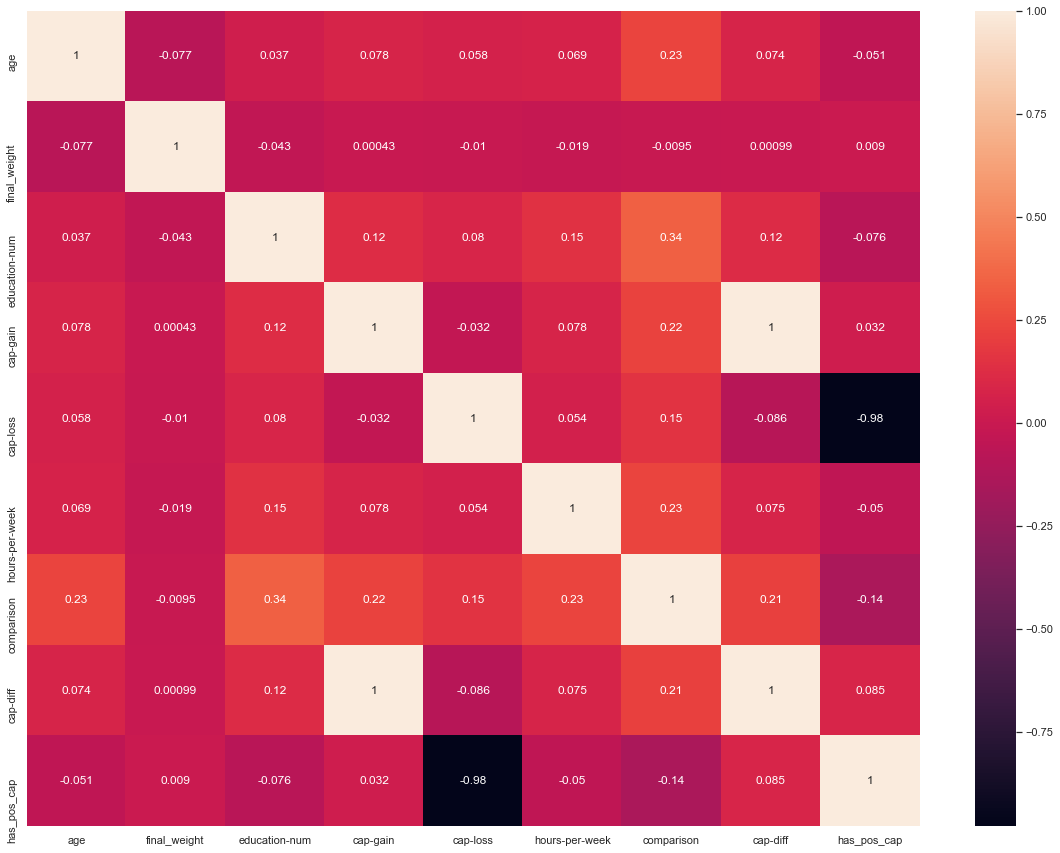

In [40]:
sns.heatmap(data=new_train_data.corr(), annot=True)

Из данной тепловой диаграммы видно, что есть колинеарные признаки cap-loss и has_pos_cap, а также cap-diff и cap-gain

Также можно видеть, что признак final_weight не сильно влияет на исход, поэтому можно избавиться и от него

In [41]:
def encode_categorical_features(df):
    le = LabelEncoder()
    le.fit(train_data['workclass'])
    df['workclass'] = le.transform(df['workclass'])
    
    le.fit(train_data['education'])
    df['education'] = le.transform(df['education'])
    
    le.fit(train_data['marital-status'])
    df['marital-status'] = le.transform(df['marital-status'])
    
    le.fit(train_data['occupation'])
    df['occupation'] = le.transform(df['occupation'])
    
    le.fit(train_data['relationship'])
    df['relationship'] = le.transform(df['relationship'])
    
    le.fit(train_data['race'])
    df['race'] = le.transform(df['race'])
    
    le.fit(train_data['sex'])
    df['sex'] = le.transform(df['sex'])
    
    le.fit(train_data['native-country'])
    df['native-country'] = le.transform(df['native-country'])
    
    
def normilize_data(df):
    from sklearn.preprocessing import normalize
    scaled_df = pd.DataFrame(normalize(df,axis=0), columns=df.columns)
    return scaled_df

Проведем факторизацию категориальных признаков

А также проведем нормализацию

In [42]:
prepared_train_data = new_train_data.copy()
encode_categorical_features(prepared_train_data)

Рассмотрим малоинформативные данные

In [43]:
n_rows, n_cols = prepared_train_data.shape
low_info_cols = []

for col in prepared_train_data.columns:
    count = prepared_train_data[col].value_counts(dropna=False)
    percent = (count / n_rows).iloc[0]
    
    if percent > 0.90: 
        low_info_cols.append(col)
        print('{0} - {1: .5f}%'.format(col, percent*100))
        print('-'*10)

cap-gain -  91.67102%
----------
cap-loss -  95.33491%
----------
has_pos_cap -  95.33491%
----------


Как можно видеть в таблице присутствуют данные с подавляющем процентом какой-то категории

Несмотря на то,что cap-gain и cap-loss имеют хорошую корреляцию с исходом их можно удалить, так как их разность 
теперь хранится в признаке cap-diff, который более информативен

has_pos_cap тоже малоинформативен

final_weight имеет слабое влияние на исход

Поэтому данные столбцы можно убрать из окончательной выборки

In [44]:
prepared_train_data = prepared_train_data.drop(columns=['final_weight', 'cap-gain', 'cap-loss', 'has_pos_cap'], axis=1)

Несмотря на их малозначимость, они имеют хорошую корреляцию с исходом

Рассмотрим дубликаты в записях

In [45]:
prepared_train_data_without_duplicates = prepared_train_data.drop_duplicates()
prepared_train_data_without_duplicates.shape

(29096, 13)

Как можно видеть, некоторые записи были дубликатом

Рассмотрим зависимости окончательных признаков на исход

In [47]:
def get_comparison_correlations(df):
    print(df.corr()['comparison'].sort_values(ascending=False))
get_comparison_correlations(prepared_train_data_without_duplicates)

comparison        1.000000
education-num     0.332210
hours-per-week    0.226323
cap-diff          0.221586
sex               0.216816
age               0.215270
education         0.091760
race              0.079826
occupation        0.073405
workclass         0.047887
native-country    0.021352
marital-status   -0.189776
relationship     -0.217789
Name: comparison, dtype: float64


Валидация модели

In [48]:
y = prepared_train_data_without_duplicates.comparison
X = prepared_train_data_without_duplicates.drop(axis=1, columns=['comparison'])

Нормализуем X

In [49]:
X = normilize_data(X)
X.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,cap-diff
0,0.005500,0.009874,0.004826,0.007298,0.007781,0.000743,0.002317,0.006273,0.007208,0.005506,0.006118,0.001617
1,0.007052,0.008463,0.004826,0.007298,0.003891,0.002971,0.000000,0.006273,0.007208,0.001790,0.006118,0.000000
2,0.005359,0.005642,0.005899,0.005052,0.000000,0.004456,0.002317,0.006273,0.007208,0.005506,0.006118,0.000000
3,0.007475,0.005642,0.000536,0.003930,0.003891,0.004456,0.000000,0.003136,0.007208,0.005506,0.006118,0.000000
4,0.003949,0.005642,0.004826,0.007298,0.003891,0.007427,0.013899,0.003136,0.000000,0.005506,0.000784,0.000000


Проведем простую проверку на точность модели, разбив пополам тренировочный и тестовый набор

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

В качестве метрики качества воспользуемся ROC-кривой

In [51]:
def plot_roc_curve(y_test, y_pred, label=None):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.figure(figsize=[20, 20])
    plt.show()
    auc_score = roc_auc_score(y_test, y_pred)
    print(auc_score)

Для начала рассмотрим дерево решений

In [53]:
tree_parameters = {'criterion' : ['gini', 'entropy'], 
                   'max_depth': range(0, 20),
                  'min_samples_split': range(2, 10)}
decision_tree = DecisionTreeClassifier()
gcv_tree = RandomizedSearchCV(decision_tree, tree_parameters, random_state=42)
gcv_tree.fit(X_train, y_train)

C:\Users\Home\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Home\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Home\.conda\envs\ml\lib\site-packages\sklearn\tree\_classes.py", line 894, in fit
    X_idx_sorted=X_idx_sorted)
  File "C:\Users\Home\.conda\envs\ml\lib\site-packages\sklearn\tree\_classes.py", line 277, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
C:\Users\Home\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to na

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(0, 20),
                                        'min_samples_split': range(2, 10)},
                   random_state=42)

In [54]:
decision_tree = gcv_tree.best_estimator_
gcv_tree.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_split=9)

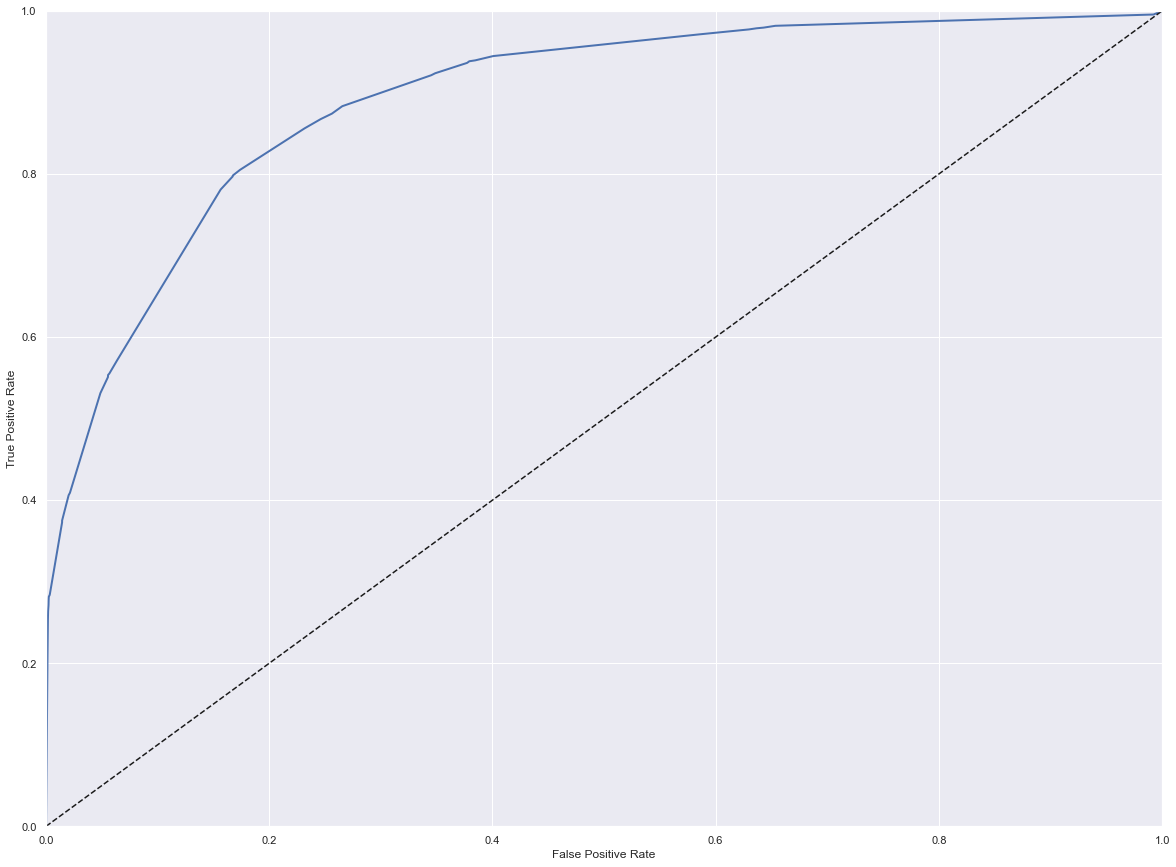

<Figure size 1440x1440 with 0 Axes>

0.8919371986893948


In [55]:
plot_roc_curve(y_test, decision_tree.predict_proba(X_test)[:, 1])

Как можно видеть точность дерева решений составило около 90%

Рассмотрим ансамбль деревьев решений

In [56]:
forest_parameters = {'n_estimators': range(1, 100),
                    'criterion': ['gini', 'entropy'],
                    'max_depth': range(0, 20),
                    'min_samples_split': range(2, 10)}
random_forest = RandomForestClassifier()
gcv_forest = RandomizedSearchCV(random_forest, forest_parameters, random_state=42)
gcv_forest.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(0, 20),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': range(1, 100)},
                   random_state=42)

In [57]:
random_forest = gcv_forest.best_estimator_
gcv_forest.best_estimator_

RandomForestClassifier(max_depth=19, min_samples_split=9, n_estimators=55)

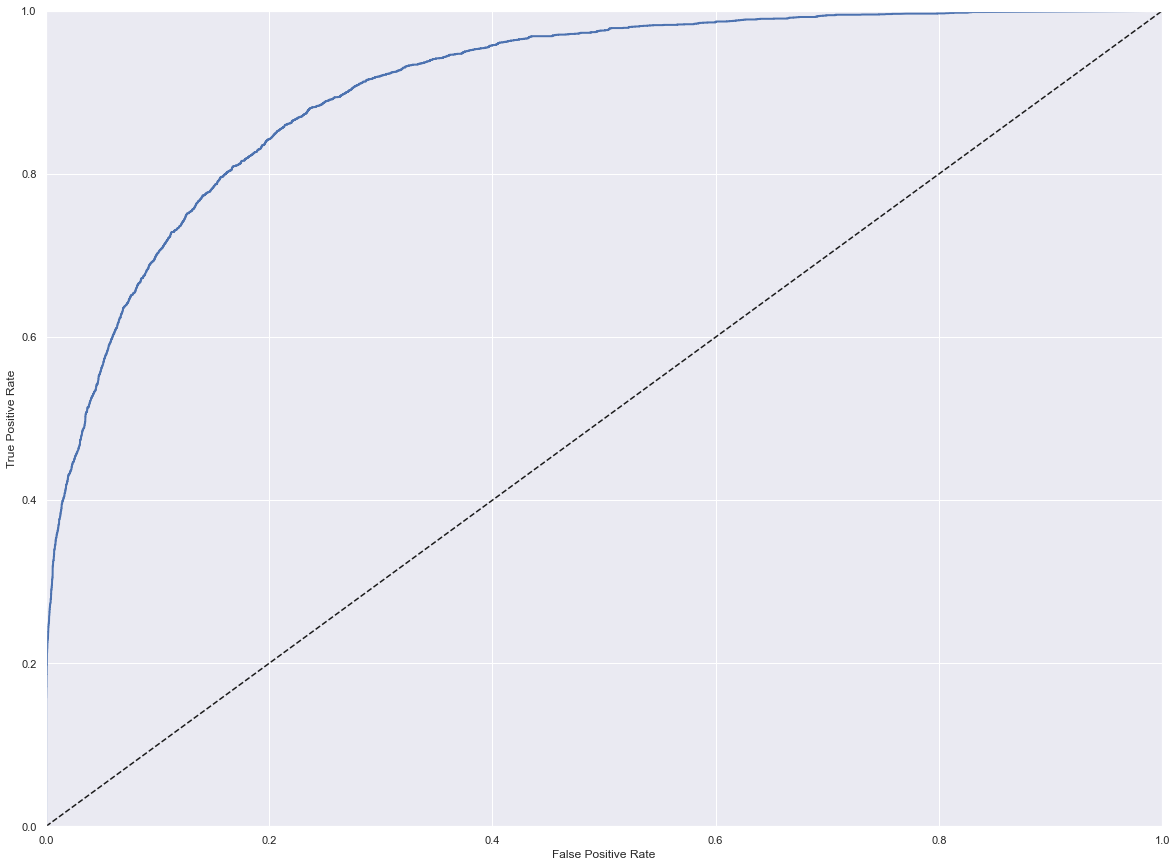

<Figure size 1440x1440 with 0 Axes>

0.9080393265657568


In [58]:
plot_roc_curve(y_test, random_forest.predict_proba(X_test)[:, 1])

Ансамбль деревьев решений дал точность около 91%

Рассмотрим градиентный бустинг LightGBM

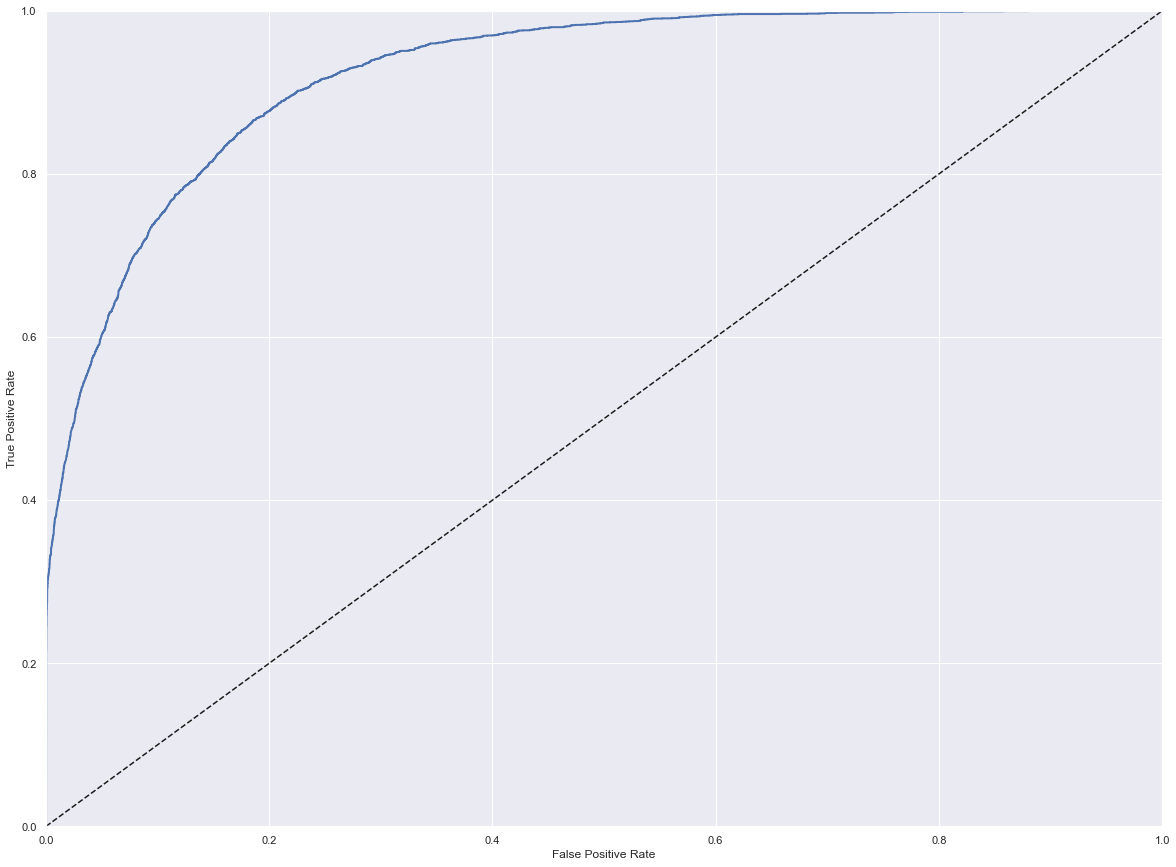

<Figure size 1440x1440 with 0 Axes>

0.9234049789500841


In [59]:
lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
plot_roc_curve(y_test, lgb_model.predict_proba(X_test)[:, 1])

Точность градиентного бустинга составило 92%

Рассмотрим алгоритм k-ближайших соседей

In [60]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_parameters = {
    'n_neighbors': range(0, 20),
    'weights': ['uniform', 'distance'],
    'leaf_size': range(0, 100),
}

gcv_knn = RandomizedSearchCV(knn, knn_parameters)
gcv_knn.fit(X_train, y_train)

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'leaf_size': range(0, 100),
                                        'n_neighbors': range(0, 20),
                                        'weights': ['uniform', 'distance']})

In [61]:
knn = gcv_knn.best_estimator_
gcv_knn.best_estimator_

KNeighborsClassifier(leaf_size=52, n_neighbors=15)

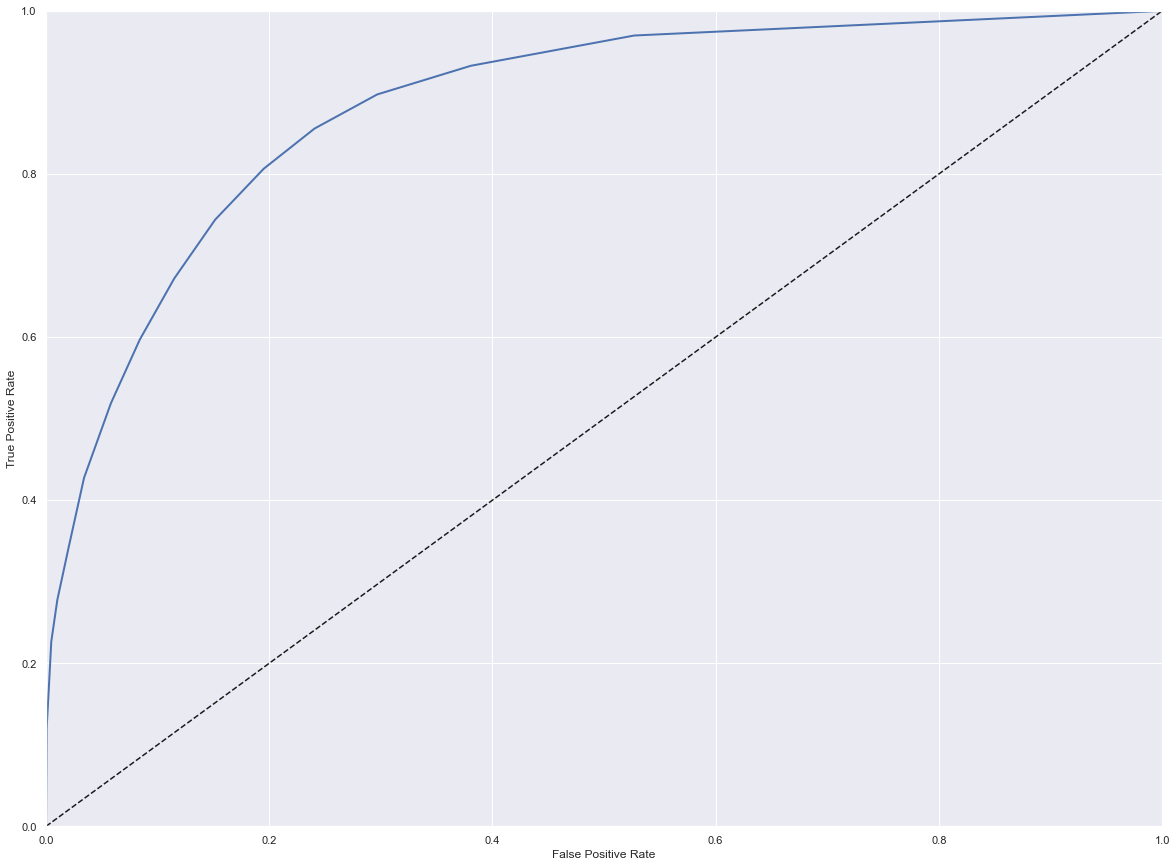

<Figure size 1440x1440 with 0 Axes>

0.8846201098322315


In [62]:
plot_roc_curve(y_test, gcv_knn.predict_proba(X_test)[:, 1])

Точность данного алгоритма составило 87%

Рассмотрим как эти модели покажут себя на кросс-валидации

При кросс-валидации будем поступать следующим образом на 3 блоках происходит обучение на 1 тест

In [63]:
def validation_model(model, X, y):
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedKFold
    
    cv = RepeatedKFold(n_splits=4, n_repeats=10, random_state=42)
    n_scores = cross_val_score(
        model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print('AUC: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Кросс-валидация дерева решений

In [64]:
validation_model(decision_tree, X_train, y_train)

AUC: 0.893 (0.006)


Кросс-валидация ансамбля деревьев решений

In [65]:
validation_model(random_forest, X_train, y_train)

AUC: 0.910 (0.005)


Кросс-валидация градиентного бустинга

In [66]:
validation_model(lgb_model, X_train, y_train)

AUC: 0.925 (0.004)


С небольшим отрывом себя хорошо показала модель градиентного бустинга с точностью 92,5%

Обучим модель на всем наборе и сдлеаем прогноз для тестовых данных

In [67]:
lgb_model.fit(X, y)

LGBMClassifier()

Загрузим тестовый набор и подготовим его к обучению

In [68]:
sum = 0
with open('test_empty.txt', 'r') as outfile, open('new_test_data.txt', 'w') as infile:
    for line in outfile:
        line_length = len(line.split(','))
        if  line_length < 14: 
            sum += 1
            print(line)
            continue
        elif line_length == 14:
            infile.write(line)
print('Удалено строк: ', sum)

|1x3 Cross validator

fssafsa121321ewd1231e2



Удалено строк:  3


In [69]:
test_data = pd.read_csv('new_test_data.txt', names=column_names)
test_data = test_data.drop(columns=['comparison'], axis=1)
test_data.head()

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country
0,25,Private,226802.0,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814.0,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951.0,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323.0,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,103497.0,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [70]:
test_data['cap-diff'] = test_data['cap-gain'] - test_data['cap-loss']

In [71]:
new_train_data.head()

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,comparison,cap-diff,has_pos_cap
0,39,state-gov,77516.0,bachelors,13,never-married,adm-clerical,not-in-family,white,male,2174.0,0.0,40,united-states,0,2174.0,1
1,50,self-emp-not-inc,83311.0,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,0.0,0.0,13,united-states,0,0.0,1
2,38,private,215646.0,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,0.0,0.0,40,united-states,0,0.0,1
3,53,private,234721.0,11th,7,married-civ-spouse,handlers-cleaners,husband,black,male,0.0,0.0,40,united-states,0,0.0,1
4,28,private,338409.0,bachelors,13,married-civ-spouse,prof-specialty,wife,black,female,0.0,0.0,40,cuba,0,0.0,1


In [72]:
category_to_lower_case(test_data)
encode_categorical_features(test_data)
test_data = normilize_data(test_data)

In [73]:
test_data = test_data.drop(columns=['final_weight', 'cap-gain', 'cap-loss'], axis=1)

In [74]:
test_data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,cap-diff
0,0.004759,0.007559,0.000714,6.842479e-11,0.010328,0.007005,0.009562,0.004160,0.009595,1.244859e-07,0.008128,0.000000
1,0.007234,0.007559,0.007852,8.797473e-11,0.005164,0.005004,0.000000,0.008321,0.009595,1.556074e-07,0.008128,0.000000
2,0.005331,0.003780,0.004997,1.172996e-10,0.005164,0.011008,0.000000,0.008321,0.009595,1.244859e-07,0.008128,0.000000
3,0.008377,0.007559,0.010708,9.774970e-11,0.005164,0.007005,0.000000,0.004160,0.009595,1.244859e-07,0.008128,0.007854
4,0.003427,0.000000,0.010708,9.774970e-11,0.010328,0.000000,0.009562,0.008321,0.000000,9.336446e-08,0.008128,0.000000


In [75]:
lgb_predict = lgb_model.predict(test_data)

In [76]:
predictions= []
for p in lgb_predict:
    if p == 0:
        predictions.append('<=N\n')
    elif p == 1:
        predictions.append('>N\n')

In [77]:
with open('predictions.txt', 'w') as file_input:
    file_input.writelines(predictions)